In [1]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.6 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
from numpy.random import seed
seed(123)

from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
from art.utils import load_dataset

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [3]:
# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('mnist'))

In [4]:
# create standard CNN in Keras and wrap with ART KerasClassifier:
def cnn_mnist(input_shape, min_val, max_val):
  
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    classifier = KerasClassifier(clip_values=(min_val, max_val), 
                                model=model, use_logits=False)
    return classifier


In [5]:
num_epochs = 10

# Construct and train a convolutional neural network
classifier = cnn_mnist(x_train.shape[1:], min_, max_)
classifier.fit(x_train, y_train, nb_epochs=num_epochs, batch_size=128)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 165us/sample - loss: 0.2160 - accuracy: 0.9356
Epoch 2/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0619 - accuracy: 0.9809
Epoch 3/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0460 - accuracy: 0.9855
Epoch 4/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.0367 - accuracy: 0.9886
Epoch 5/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0298 - accuracy: 0.9905
Epoch 6/10
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0251 - accuracy: 0.9920
Epoch 7/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0219 - accuracy: 0.9930
Epoch 8/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0183 - accuracy: 0.9939
Epoch 9/10
60000/60000 [==============================] - 3s 48us/sample - loss: 0.0159 - accuracy: 0.9947
Epoch 10/10


In [6]:
# Create the attack.
# Note: by setting the threshold to 1., the attack will effectively exhaust the maximum number of iterations.

attack = MIFace(classifier, max_iter=10000, threshold=1.) 

In [7]:
# Our attack target in the following will be to infer information about the training samples 
# for each of the 10 MNIST CLASSES:

y = np.arange(10)

In [9]:
# We will experiment with a number of different initializations:

x_init_white = np.zeros((10, 28, 28, 1))
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
x_init_black = np.ones((10, 28, 28, 1))
x_init_random = np.random.uniform(0, 1, (10, 28, 28, 1))
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)

print(np.mean(x_test, axis=0))

[[[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [1.49019608e-05]
  [9.25490196e-05]
  [6.19607843e-05]
  [1.58039216e-04]
  [2.00392157e-04]
  [4.10588235e-04]
  [9.18823529e-04]
  [1.21098039e-03]
  [1.04313725e-03]
  [1.20823529e-03]
  [9.18823529e-04]
  [2.70980392e-04]
  [3.51764706e-04]
  [3.68627451e-04]
  [1.96862745e-04]
  [7.52941176e-05]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000

In [ ]:
# We observe that the classifier's gradients are vanishing on white images, therefore the attack won't work:
print("Maximum class gradient: %f" % (np.max(np.abs(classifier.class_gradient(x_init_white, y)))))

Maximum class gradient: 0.025180


In [ ]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.008711


In [ ]:
%%time

# Now we run the attack:
x_infer_from_grey = attack.infer(x_init_grey, y)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 5min 28s, sys: 18.7 s, total: 5min 47s
Wall time: 4min 33s


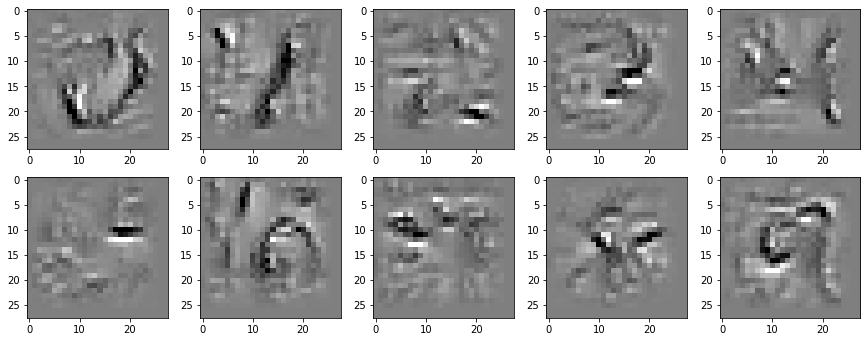

In [ ]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (28, 28))), cmap=plt.cm.gray_r)

In [ ]:
%%time

# Now we run the attack:
x_infer_from_average = attack.infer(x_init_average, y)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (28, 28))), cmap=plt.cm.gray_r)